# The TESS full-frame images lightcurve of nova PGIR22akgylf extracted using LightKurve package


The eruption of PGIR22akgylf was happening during the TESS Sector 55. We extract lightcurves for the nova and two nearby check stars (as well as the background off-source lightcurves associated with each of these objects) using circular source apertures and ring-like background regions. A range of source and background region sizes is used as well as two aperture centering techniques:
1. placing the aperture at the input euqtorial coordinates (converted to pixel coordinates on the fly)
2. calculate the centroid position and use it for placing the aperture
The best lightcurve is selected among all the variants. The best lightcurve is defined to be the one that is characterised by the smallest Median Absolute Deviation among the lightcurve variants.

The best lightcurve is detrended before running the period search. The period of ~0.1277 days is present in the nova lightcurve, but not in the lightcurves of the check stars, as expected for an astrophysical signal. The background level is experiencing modulation with a period of 0.333 days. This modulation is present in the background lightcurves of the nova as well as the background lightcurves of the check stars, suggesting an instrumental origin.

In [1]:
# Import the packages
import os
import matplotlib.pyplot as plt
import lightkurve as lk  # Importing the lightkurve library for working with TESS data
from photutils.centroids import centroid_com  # Importing function for calculating centroid
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry  # Importing photometry functions
from astropy.stats import sigma_clipped_stats  # Importing sigma-clipped statistics
from lightkurve import LightCurve  # Importing LightCurve class
import numpy as np  # Importing numpy for numerical operations
from astropy.visualization import simple_norm  # Importing visualization tools
from astropy.time import Time  # Importing Time class for handling time conversions
import warnings  # Importing warnings to suppress specific warnings

# Suppress specific warnings from astropy.stats.sigma_clipping
warnings.filterwarnings('ignore', message='Input data contains invalid values', category=UserWarning, module='astropy.stats.sigma_clipping')

# Lightkurve cuts on image quality flags
qualitycuts = 'hard'

from astropy.coordinates import SkyCoord  # Importing SkyCoord class for coordinate conversions
from astropy import units as u  # Importing units from astropy

# Switch to enable or disable writing of all lightcurves
WRITE_ALL_LIGHTCURVES = False

# Switch to enable or disable writing of the best lightcurve in the units of electrons/s
WRITE_BEST_LIGHTCURVE_ELECTRONS = True

# Switch to enable or disable writing of the best lightcurve in the units of magnitude
WRITE_BEST_LIGHTCURVE_MAGNITUDES = True

/home/kirill/.conda/envs/lk/lib/python3.10/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /home/kirill/.lightkurve/cache. Please move all the files in the legacy directory /home/kirill/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
def simple_detrend_and_period_search(lc, period_range=(0.05, 3.0), titleprefixstring=""):
    """
    Process a LightCurve: clip outliers, detrend, and perform Lomb-Scargle period search.
    Parameters:
    lc (LightCurve): The LightCurve object to process.
    period_range (tuple): The range of periods (in days) to search for periods, default is (0.05, 3.0).
    titleprefixstring (str): A prefix string for titles in the generated plots.
    Returns:
    float: The best period detected by the Lomb-Scargle periodogram.
    Workflow:
    1. Clip Outliers (3-sigma): Removes significant outliers from the lightcurve to clean the data.
    2. Detrend the LightCurve: Uses a 5th-degree Savitzky-Golay filter and subtracts the trend.
    3. Re-clip After Detrending: Removes outliers after detrending.
    4. Lomb-Scargle Period Analysis:
       - Converts the specified period range into frequency range.
       - Computes the Lomb-Scargle periodogram.
       - Identifies the best period (highest power).
    5. Generate Plots:
       - Display the sigma-clipped lightcurve.
       - Display the detrended lightcurve.
       - Display the sigma-clipped lightcurve after detrending.
       - Plot the Lomb-Scargle periodogram as a function of frequency, highlighting the best period.
       - Plot the phased lightcurve with phase 0 at minimum flux.
   
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Step 1: Clip the lightcurve at 3-sigma
    clipped_lc = lc.remove_outliers(sigma=3)
    clipped_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{titleprefixstring} sigma-clipped")
    plt.show()
    
    # Step 2: Detrend the lightcurve using Savitzky-Golay filter and subtraction
    from scipy.signal import savgol_filter
    from lightkurve import LightCurve
    
    # Get the time and flux arrays
    time = clipped_lc.time.value
    flux = clipped_lc.flux.value
    
    # Compute the trend using the same parameters as in flatten()
    trend = savgol_filter(flux, window_length=101, polyorder=5)
    
    # Create a new lightcurve with the detrended flux (subtraction)
    detrended_lc = LightCurve(time=clipped_lc.time, flux=flux - trend)
    detrended_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{titleprefixstring} sigma-clipped, detrended (subtraction)")
    plt.show()
    
    # Step 2.5: Clip the lightcurve again (to remove mini-flares in nova V606 Vul lightcurve)
    detrended_lc = detrended_lc.remove_outliers(sigma=3)
    detrended_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{titleprefixstring} sigma-clipped, detrended (subtraction), sigma-clipped")
    plt.show()    
    
    # Step 3: Perform Lomb-Scargle periodogram analysis using LightKurve's built-in functionality
    min_period, max_period = period_range
    min_frequency = 1 / max_period
    max_frequency = 1 / min_period
    
    # Create the periodogram
    periodogram = detrended_lc.to_periodogram(method="lombscargle", 
                                              minimum_frequency=min_frequency, 
                                              maximum_frequency=max_frequency)
    
    # Find and print the best period
    best_period = periodogram.period_at_max_power
    print(f"The best period is: {best_period:.4f} days")
    
    # Step 4: Plot the periodogram as a function of frequency
    plt.figure(figsize=(10, 5))
    plt.plot(periodogram.frequency.value, periodogram.power, label="Lomb-Scargle Power")
    plt.axvline(x=1/best_period.value, color="red", linestyle="--", label=f"Best Period = {best_period:.4f} days")
    plt.xlabel("Frequency (1/day)")
    plt.ylabel("Power")
    plt.title(f"{titleprefixstring} Lomb-Scargle Periodogram")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Step 5: Create phased lightcurve plot with sine wave fit to determine phase 0
    from scipy.optimize import curve_fit
    
    time_values = detrended_lc.time.value
    flux_values = detrended_lc.flux.value
    
    # Calculate initial phases
    phases = (time_values - time_values[0]) / best_period.value % 1
    
    # Define sine wave function for fitting
    def sine_wave(phase, amplitude, phase_offset, vertical_offset):
        return amplitude * np.sin(2 * np.pi * (phase - phase_offset)) + vertical_offset
    
    # Initial guess for parameters
    amplitude_guess = (np.max(flux_values) - np.min(flux_values)) / 2
    vertical_offset_guess = np.mean(flux_values)
    phase_offset_guess = 0
    
    # Fit sine wave to the data
    try:
        popt, pcov = curve_fit(sine_wave, phases, flux_values, 
                              p0=[amplitude_guess, phase_offset_guess, vertical_offset_guess],
                              maxfev=5000)
        amplitude_fit, phase_offset_fit, vertical_offset_fit = popt
        
        # For sin(2π(φ - φ₀)), minimum occurs when 2π(φ - φ₀) = -π/2 + 2πn
        # So φ_min = φ₀ - 1/4 (taking n=0 and adjusting to [0,1))
        phase_of_minimum = (phase_offset_fit - 0.25) % 1
        
        # If amplitude is negative, the function is inverted (max becomes min)
        if amplitude_fit < 0:
            amplitude_fit = -amplitude_fit
            phase_of_minimum = (phase_of_minimum + 0.5) % 1  # Shift by half period
        
        print(f"Fitted sine wave parameters:")
        print(f"  Amplitude: {amplitude_fit:.6f}")
        print(f"  Phase offset: {phase_offset_fit:.6f}")
        print(f"  Vertical offset: {vertical_offset_fit:.6f}")
        print(f"  Phase of minimum: {phase_of_minimum:.6f}")
        
        # Adjust phases so fitted minimum occurs at phase 0
        adjusted_phases = (phases - phase_of_minimum) % 1
        
        # Update the phase offset for plotting the fitted curve
        adjusted_phase_offset = (phase_offset_fit - phase_of_minimum) % 1
        
    except Exception as e:
        print(f"Sine wave fitting failed: {e}")
        print("Using simple minimum finding instead...")
        # Fallback to simple minimum finding
        min_flux_idx = np.argmin(flux_values)
        phase_of_minimum = phases[min_flux_idx]
        adjusted_phases = (phases - phase_of_minimum) % 1
        # Set dummy values for plotting
        amplitude_fit, adjusted_phase_offset, vertical_offset_fit = amplitude_guess, 0, vertical_offset_guess
    
    # Create the phased lightcurve plot from -0.5 to 1.5
    plt.figure(figsize=(12, 7))
    
    # Create extended phase arrays for plotting from -0.5 to 1.5
    extended_phases = []
    extended_flux = []
    
    for phase_shift in [-1, 0, 1]:
        extended_phases.extend(adjusted_phases + phase_shift)
        extended_flux.extend(flux_values)
    
    extended_phases = np.array(extended_phases)
    extended_flux = np.array(extended_flux)
    
    # Filter to plot range -0.5 to 1.5
    plot_mask = (extended_phases >= -0.5) & (extended_phases <= 1.5)
    plot_phases = extended_phases[plot_mask]
    plot_flux = extended_flux[plot_mask]
    
    # Plot the data points
    plt.scatter(plot_phases, plot_flux, alpha=0.6, s=20, color='tab:blue', label='')
    
    # Create binned version for cleaner visualization
    phase_bins = np.linspace(-0.5, 1.5, 20)
    binned_flux = []
    binned_flux_err = []
    bin_centers = []
    
    for i in range(len(phase_bins)-1):
        mask = (plot_phases >= phase_bins[i]) & (plot_phases < phase_bins[i+1])
        if np.sum(mask) > 0:
            binned_flux.append(np.mean(plot_flux[mask]))
            binned_flux_err.append(np.std(plot_flux[mask]) / np.sqrt(np.sum(mask)))
            bin_centers.append((phase_bins[i] + phase_bins[i+1]) / 2)
    
    bin_centers = np.array(bin_centers)
    binned_flux = np.array(binned_flux)
    binned_flux_err = np.array(binned_flux_err)
    
    # Plot binned data
    if len(bin_centers) > 0:
        plt.errorbar(bin_centers, binned_flux, yerr=binned_flux_err, 
                    color='tab:red', marker='o', markersize=4, linewidth=2, 
                    label='Binned', capsize=3, linestyle='None')
    
    # Plot the fitted sine wave
    phase_fine = np.linspace(-0.5, 1.5, 500)
    try:
        # Plot the fitted curve in the adjusted phase coordinate system
        # The sine wave should have its minimum at phase 0 in the adjusted coordinates
        fitted_curve = amplitude_fit * np.sin(2 * np.pi * (phase_fine - 0.25)) + vertical_offset_fit
        plt.plot(phase_fine, fitted_curve, 'g-', linewidth=2, label='Fitted sine wave')
    except:
        pass
    
    # Add vertical lines at key phases
    plt.axvline(x=0, color='green', linestyle='--', alpha=0.7, label='Phase 0')
    plt.axvline(x=-1, color='green', linestyle='--', alpha=0.5)
    plt.axvline(x=1, color='green', linestyle='--', alpha=0.5)
    
    plt.xlabel('Phase')
    plt.ylabel('Flux')
    plt.title(f'{titleprefixstring} Phased Lightcurve (Period = {best_period:.4f} days)')
    plt.xlim(-0.5, 1.5)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    return best_period.value



Target Name: PGIR22akgylf
Target RA/DEC: 20:00:29.26 +34:53:09.1
SearchResult containing 8 data products.

 #     mission     year  author exptime       target_name       distance
                                   s                             arcsec 
--- -------------- ---- ------- ------- ----------------------- --------
  0 TESS Sector 14 2019 TESScut    1426 20:00:29.26 +34:53:09.1      0.0
  1 TESS Sector 15 2019 TESScut    1426 20:00:29.26 +34:53:09.1      0.0
  2 TESS Sector 54 2022 TESScut     475 20:00:29.26 +34:53:09.1      0.0
  3 TESS Sector 55 2022 TESScut     475 20:00:29.26 +34:53:09.1      0.0
  4 TESS Sector 74 2024 TESScut     158 20:00:29.26 +34:53:09.1      0.0
  5 TESS Sector 75 2024 TESScut     158 20:00:29.26 +34:53:09.1      0.0
  6 TESS Sector 81 2024 TESScut     158 20:00:29.26 +34:53:09.1      0.0
  7 TESS Sector 82 2024 TESScut     158 20:00:29.26 +34:53:09.1      0.0
Extracting TESS Sector 55 lightcurve of PGIR22akgylf with aperture radius 1.5 pix and back

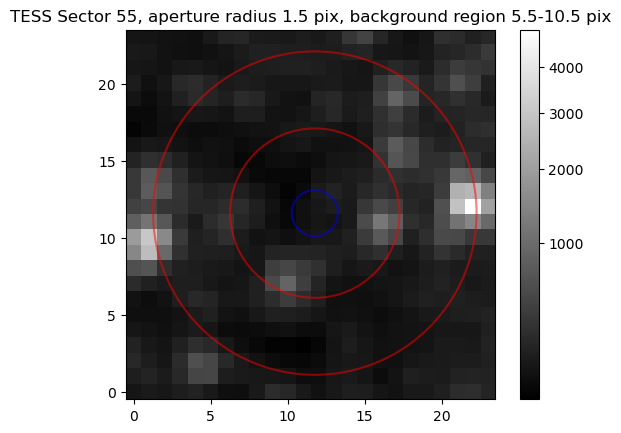

MAD for input_position, aperture radius 1.5, annulus 5.5-10.5: 121.94773449253921 electron / s
Best lightcurve: aperture radius: 1.5 pix, background ring: 5.5-10.5 pix
Writing best lightcurve to file pgir22akgylf_lk_circular_aperture/PGIR22akgylf_best_TESS_lightcurve.csv
Writing best background lightcurve to file pgir22akgylf_lk_circular_aperture/PGIR22akgylf_best_TESS_background.csv
Writing best lightcurve (magnitudes) to file pgir22akgylf_lk_circular_aperture/PGIR22akgylf_best_TESS_lightcurve_mag.dat
Plotting magnitude lightcurve for PGIR22akgylf:
  - Data points: 1919
  - Time range: 2459810.888 to 2459824.263 JD
  - Magnitude range: 13.551 to 17.162 mag
  - Configuration: aperture radius: 1.5 pix, background ring: 5.5-10.5 pix


/tmp/ipykernel_529893/2847121557.py:146: RuntimeWarning: invalid value encountered in log10
  mag_err = -2.5 * np.log10((flux - flux_err) / flux)  # Calculate magnitude error


Plotting flux lightcurve for PGIR22akgylf:
  - Data points: 1919
  - Time range: 2810.888 to 2824.263 BTJD
  - Flux range: 20.5 to 569.8 e-/s
  - Configuration: aperture radius: 1.5 pix, background ring: 5.5-10.5 pix


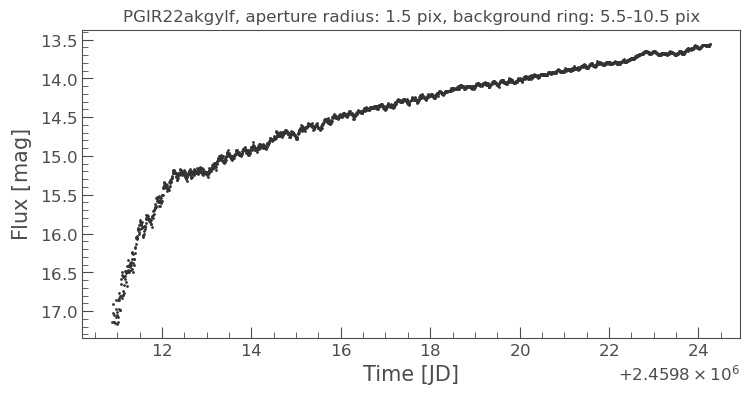

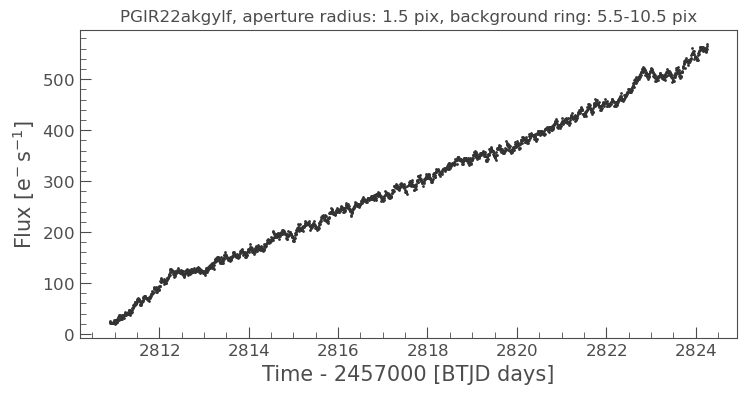

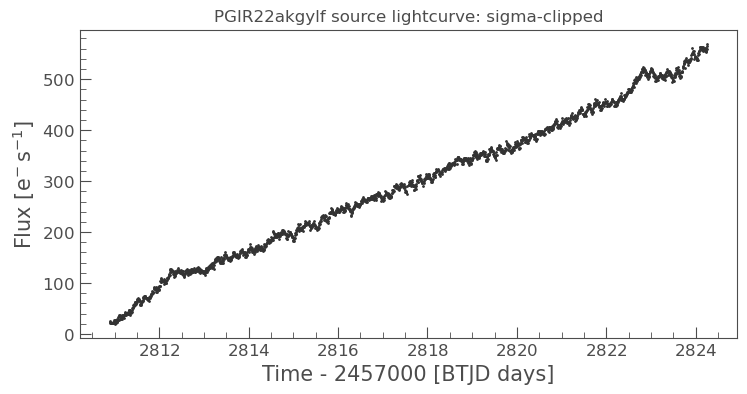

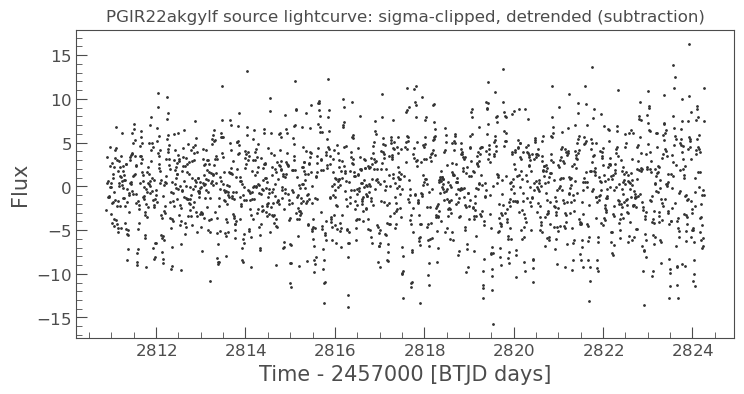

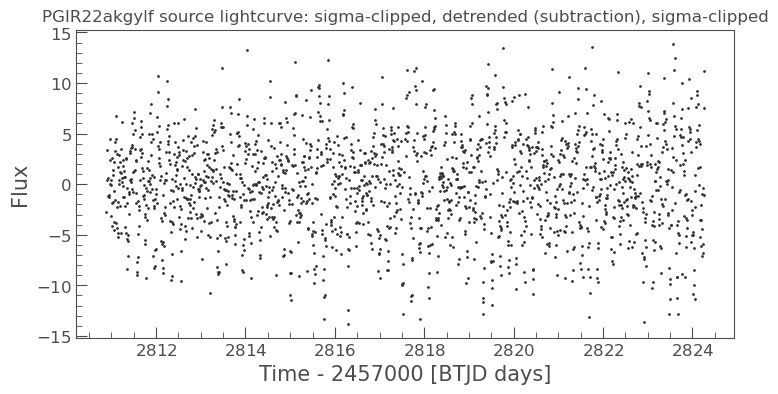

The best period is: 0.1801 d days


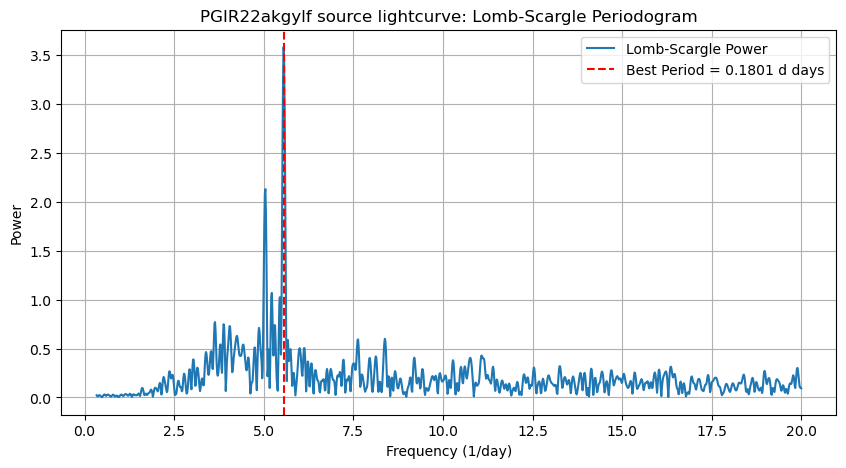

Fitted sine wave parameters:
  Amplitude: 3.582822
  Phase offset: 0.162864
  Vertical offset: 0.001738
  Phase of minimum: 0.912864


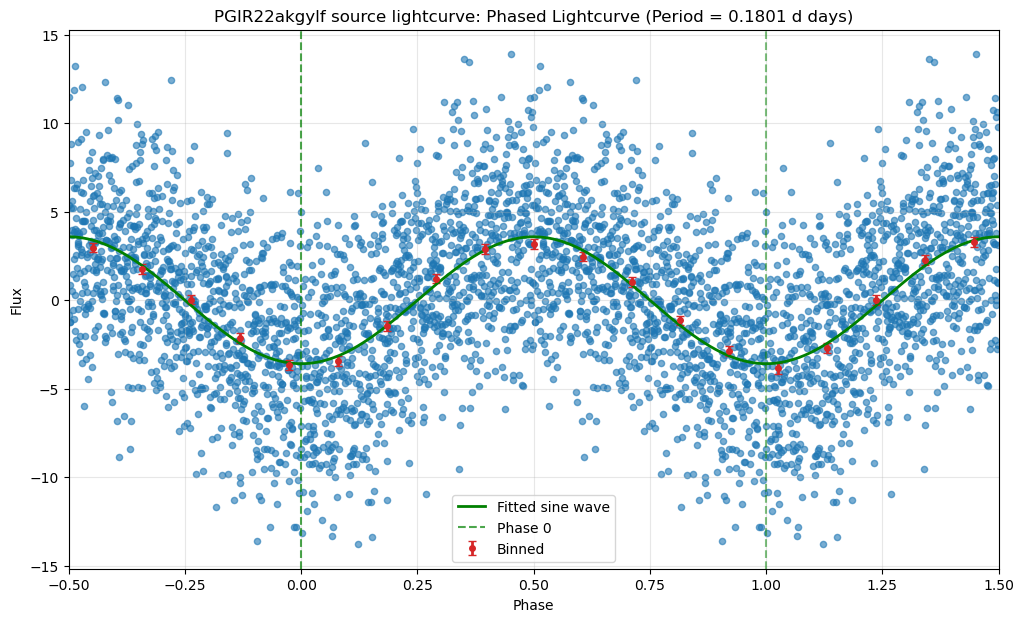

Plotting background lightcurve for PGIR22akgylf:
  - Data points: 1919
  - Time range: 2810.888 to 2824.263 BTJD
  - Background flux range: 175.0 to 271.9 e-/s/pix
  - Configuration: aperture radius: 1.5 pix, background ring: 5.5-10.5 pix


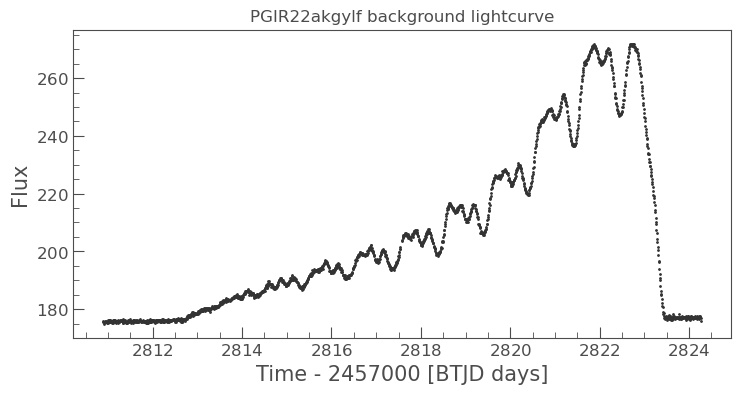

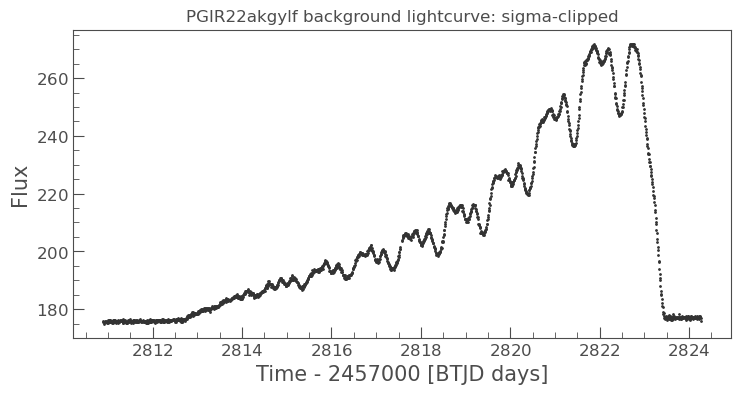

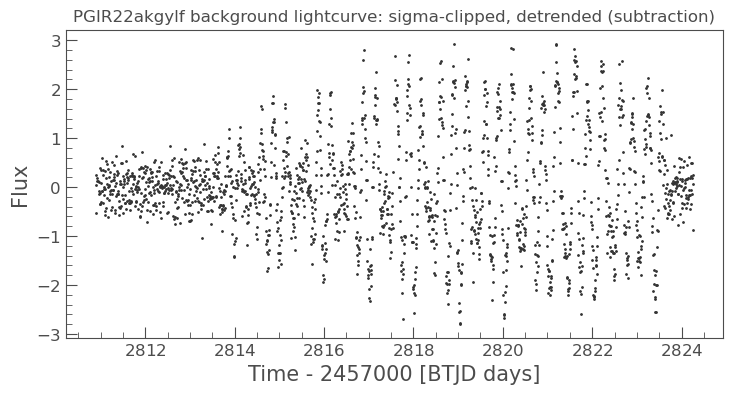

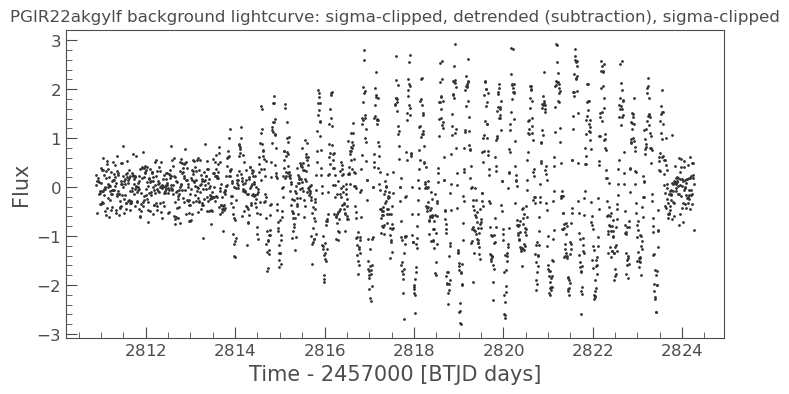

The best period is: 0.3356 d days


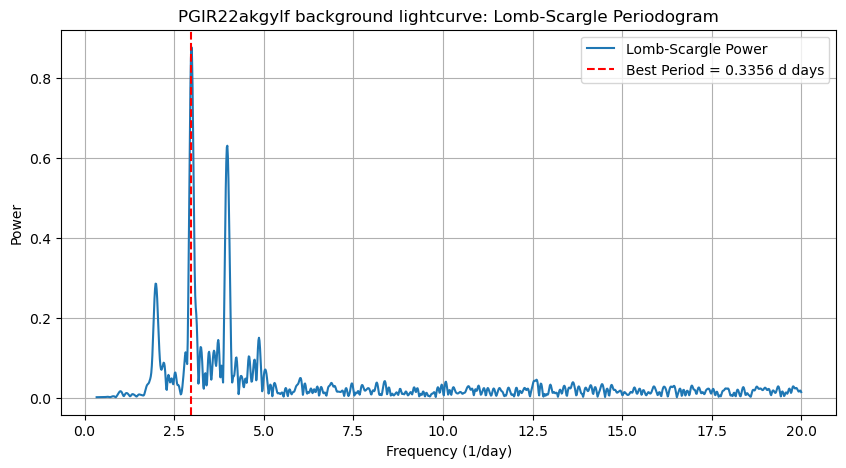

Fitted sine wave parameters:
  Amplitude: 0.878220
  Phase offset: 0.094748
  Vertical offset: 0.003709
  Phase of minimum: 0.344748


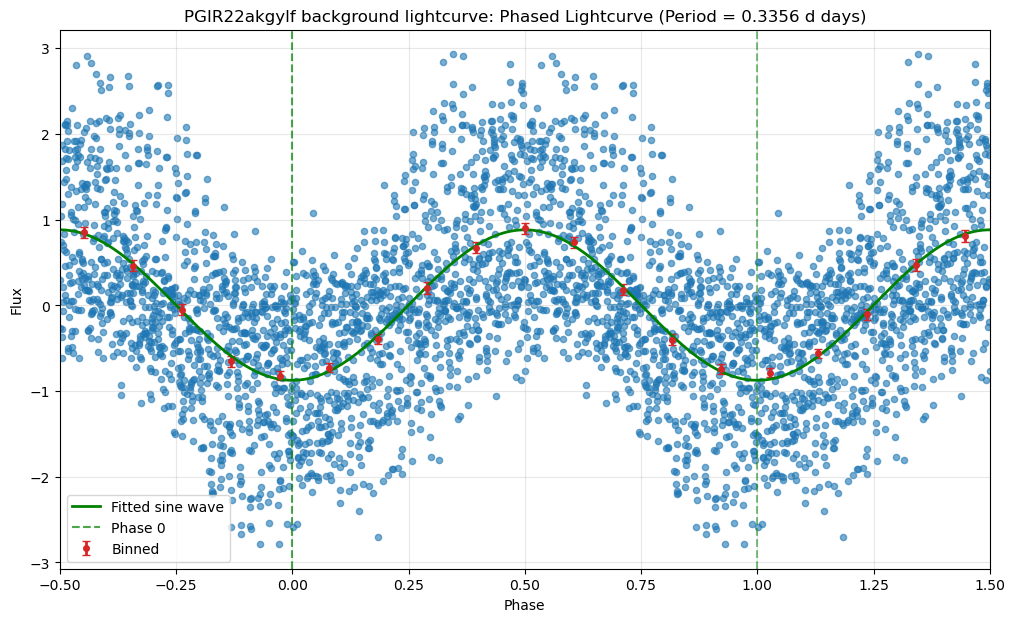

Target Name: TYC 2678-1207-1
Target RA/DEC: 20:00:30.1586813 +34:51:34.456302
SearchResult containing 8 data products.

 #     mission     year  author exptime            target_name            distance
                                   s                                       arcsec 
--- -------------- ---- ------- ------- --------------------------------- --------
  0 TESS Sector 14 2019 TESScut    1426 20:00:30.1586813 +34:51:34.456302      0.0
  1 TESS Sector 15 2019 TESScut    1426 20:00:30.1586813 +34:51:34.456302      0.0
  2 TESS Sector 54 2022 TESScut     475 20:00:30.1586813 +34:51:34.456302      0.0
  3 TESS Sector 55 2022 TESScut     475 20:00:30.1586813 +34:51:34.456302      0.0
  4 TESS Sector 74 2024 TESScut     158 20:00:30.1586813 +34:51:34.456302      0.0
  5 TESS Sector 75 2024 TESScut     158 20:00:30.1586813 +34:51:34.456302      0.0
  6 TESS Sector 81 2024 TESScut     158 20:00:30.1586813 +34:51:34.456302      0.0
  7 TESS Sector 82 2024 TESScut     158 20:00:30.1

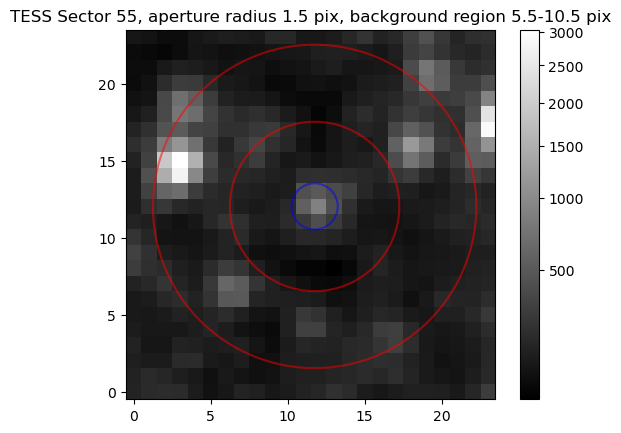

MAD for input_position, aperture radius 1.5, annulus 5.5-10.5: 2.97352316870456 electron / s
Best lightcurve: aperture radius: 1.5 pix, background ring: 5.5-10.5 pix
Writing best lightcurve to file pgir22akgylf_lk_circular_aperture/TYC_2678-1207-1_best_TESS_lightcurve.csv
Writing best background lightcurve to file pgir22akgylf_lk_circular_aperture/TYC_2678-1207-1_best_TESS_background.csv
Writing best lightcurve (magnitudes) to file pgir22akgylf_lk_circular_aperture/TYC_2678-1207-1_best_TESS_lightcurve_mag.dat
Plotting magnitude lightcurve for TYC 2678-1207-1:
  - Data points: 3771
  - Time range: 2459797.111 to 2459824.263 JD
  - Magnitude range: 12.058 to 12.072 mag
  - Configuration: aperture radius: 1.5 pix, background ring: 5.5-10.5 pix
Plotting flux lightcurve for TYC 2678-1207-1:
  - Data points: 3771
  - Time range: 2797.111 to 2824.263 BTJD
  - Flux range: 2224.0 to 2254.0 e-/s
  - Configuration: aperture radius: 1.5 pix, background ring: 5.5-10.5 pix


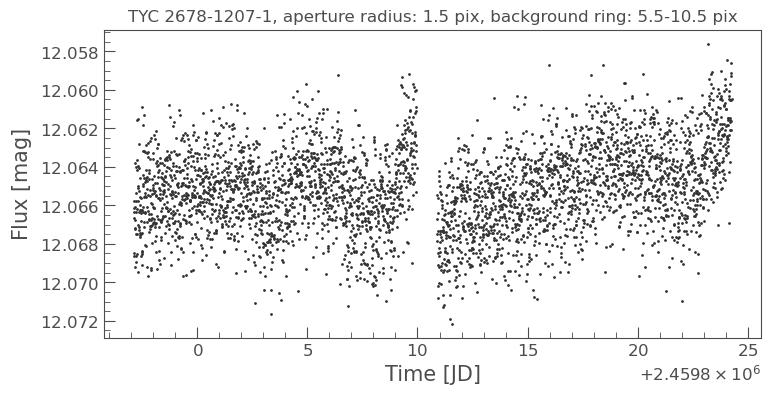

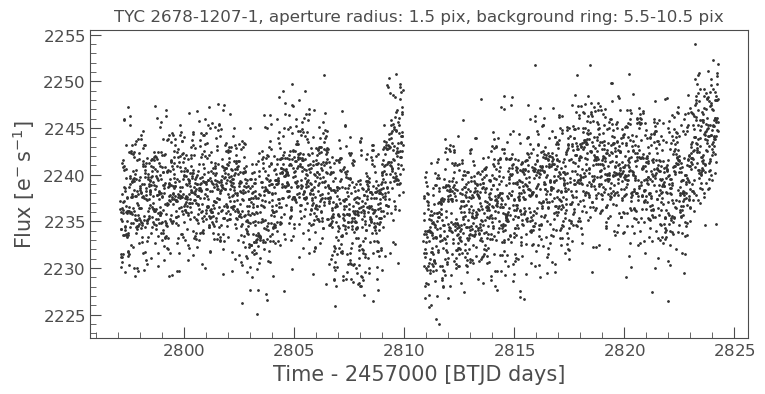

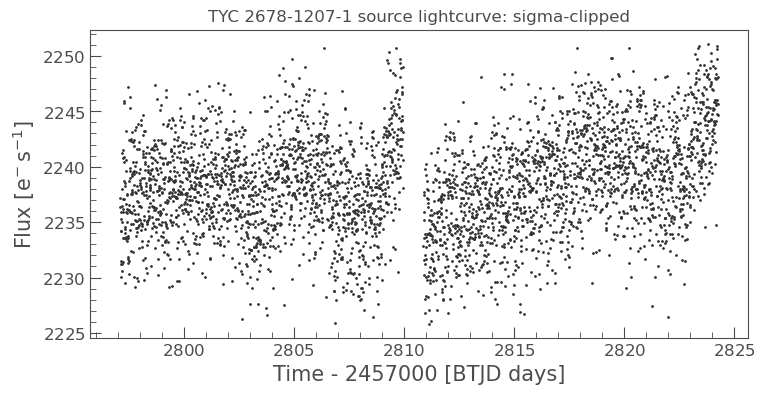

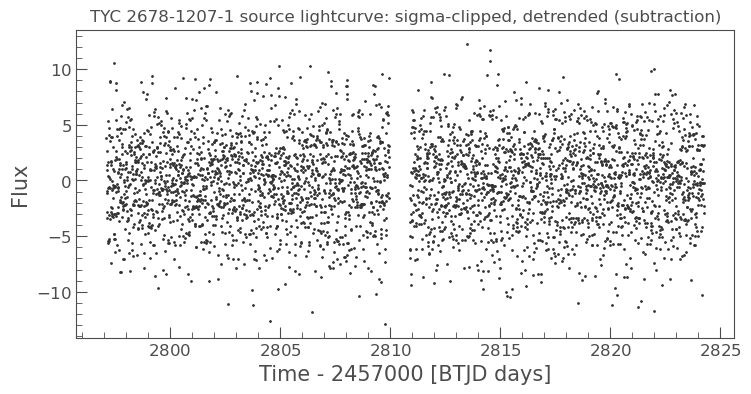

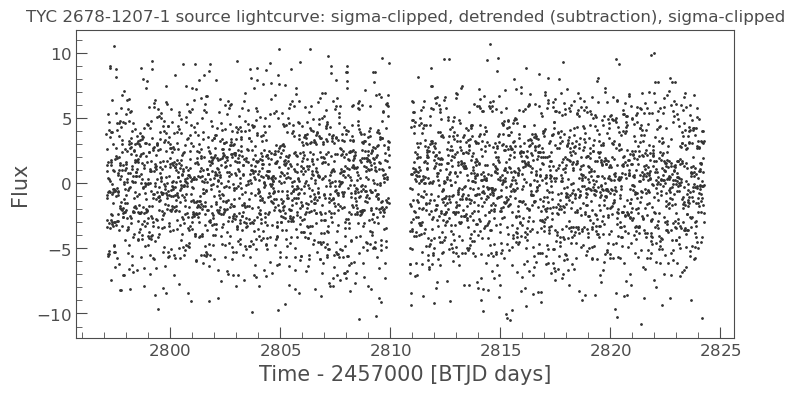

The best period is: 0.1361 d days


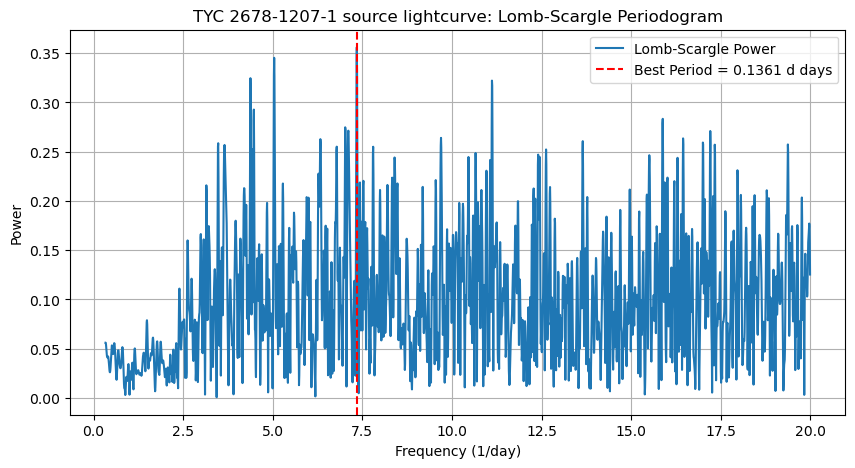

Fitted sine wave parameters:
  Amplitude: 0.355706
  Phase offset: -0.162199
  Vertical offset: 0.020918
  Phase of minimum: 0.587801


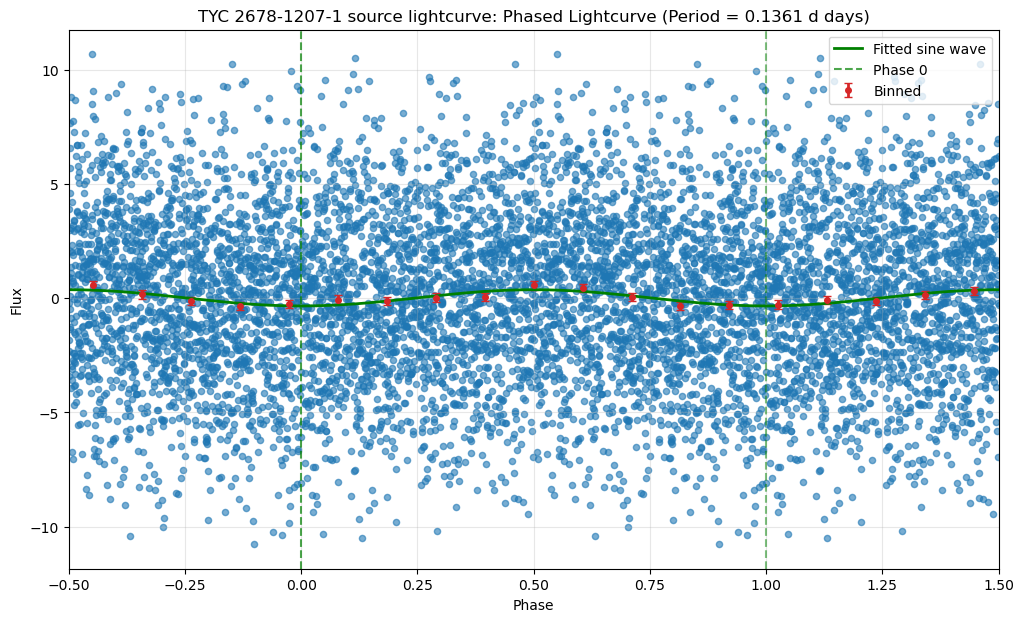

Plotting background lightcurve for TYC 2678-1207-1:
  - Data points: 3771
  - Time range: 2797.111 to 2824.263 BTJD
  - Background flux range: 174.0 to 287.1 e-/s/pix
  - Configuration: aperture radius: 1.5 pix, background ring: 5.5-10.5 pix


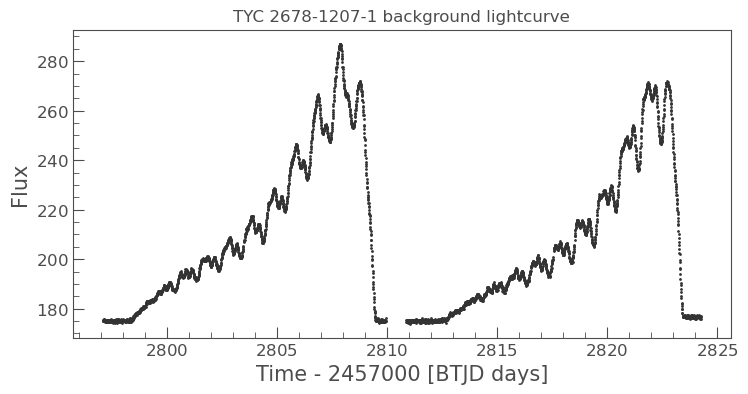

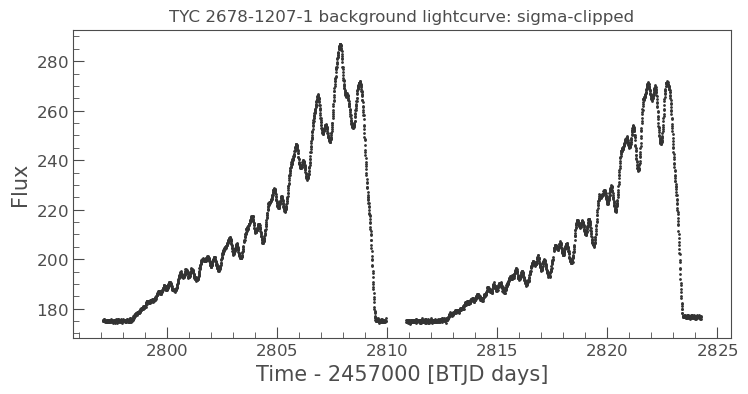

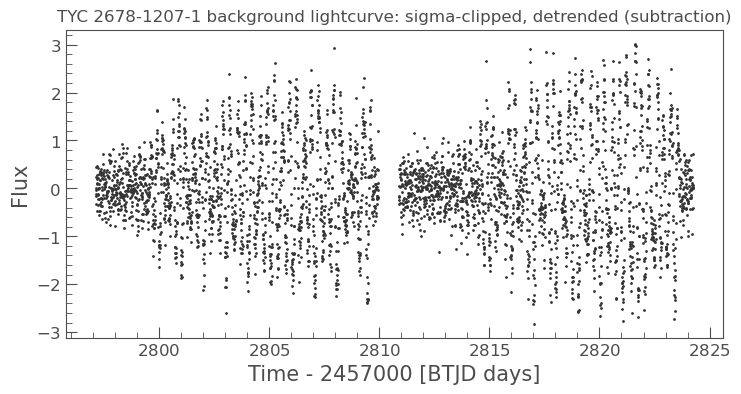

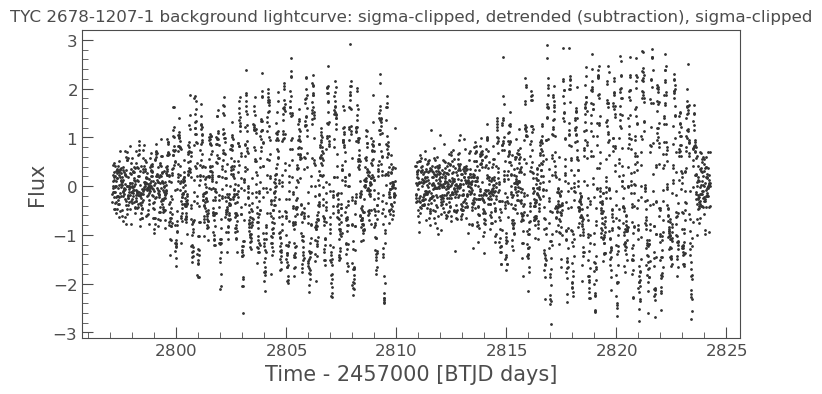

The best period is: 0.3334 d days


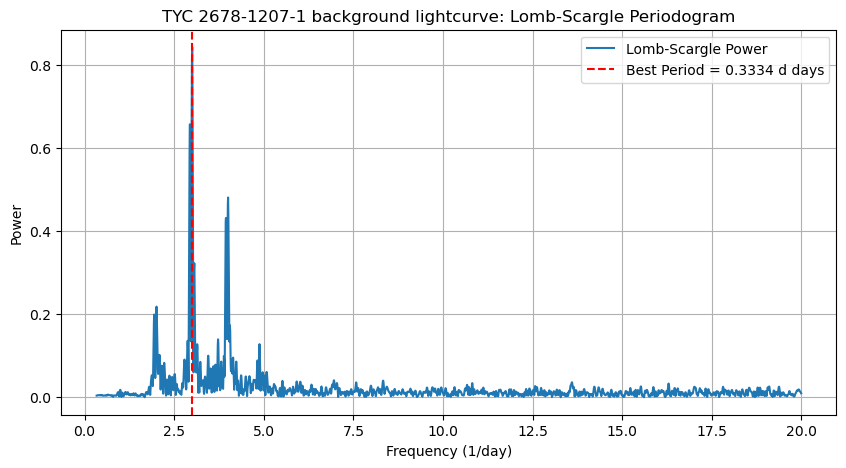

Fitted sine wave parameters:
  Amplitude: 0.841744
  Phase offset: 0.102891
  Vertical offset: -0.005247
  Phase of minimum: 0.852891


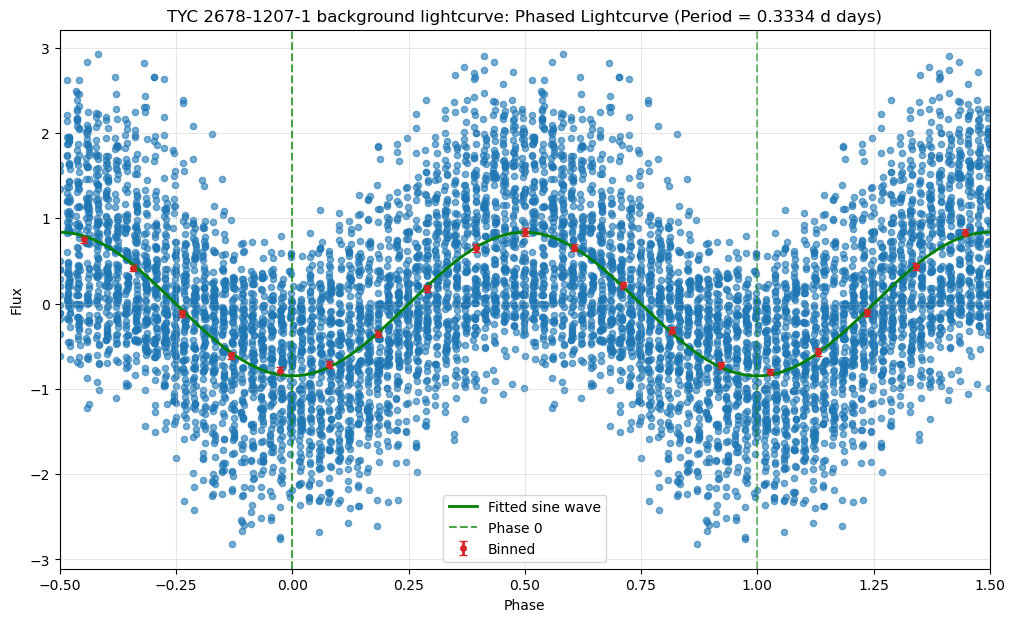

Target Name: ATO J300.1356+34.8776
Target RA/DEC: 20:00:32.5503041 +34:52:39.529398
SearchResult containing 8 data products.

 #     mission     year  author exptime            target_name            distance
                                   s                                       arcsec 
--- -------------- ---- ------- ------- --------------------------------- --------
  0 TESS Sector 14 2019 TESScut    1426 20:00:32.5503041 +34:52:39.529398      0.0
  1 TESS Sector 15 2019 TESScut    1426 20:00:32.5503041 +34:52:39.529398      0.0
  2 TESS Sector 54 2022 TESScut     475 20:00:32.5503041 +34:52:39.529398      0.0
  3 TESS Sector 55 2022 TESScut     475 20:00:32.5503041 +34:52:39.529398      0.0
  4 TESS Sector 74 2024 TESScut     158 20:00:32.5503041 +34:52:39.529398      0.0
  5 TESS Sector 75 2024 TESScut     158 20:00:32.5503041 +34:52:39.529398      0.0
  6 TESS Sector 81 2024 TESScut     158 20:00:32.5503041 +34:52:39.529398      0.0
  7 TESS Sector 82 2024 TESScut     158 20:0

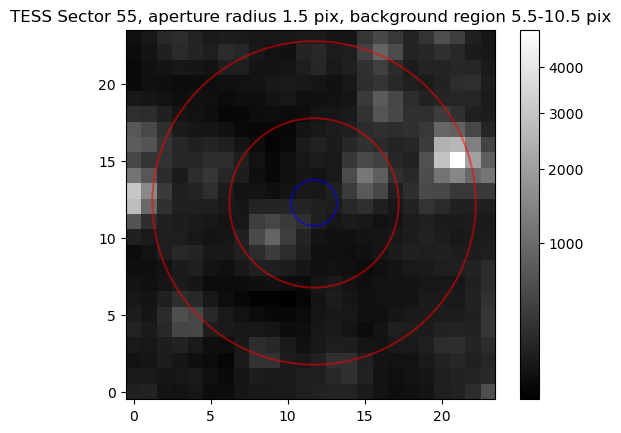

MAD for input_position, aperture radius 1.5, annulus 5.5-10.5: 12.818600519454321 electron / s
Best lightcurve: aperture radius: 1.5 pix, background ring: 5.5-10.5 pix
Writing best lightcurve to file pgir22akgylf_lk_circular_aperture/ATO_J300.1356+34.8776_best_TESS_lightcurve.csv
Writing best background lightcurve to file pgir22akgylf_lk_circular_aperture/ATO_J300.1356+34.8776_best_TESS_background.csv
Writing best lightcurve (magnitudes) to file pgir22akgylf_lk_circular_aperture/ATO_J300.1356+34.8776_best_TESS_lightcurve_mag.dat
Plotting magnitude lightcurve for ATO J300.1356+34.8776:
  - Data points: 3771
  - Time range: 2459797.111 to 2459824.263 JD
  - Magnitude range: 14.114 to 14.403 mag
  - Configuration: aperture radius: 1.5 pix, background ring: 5.5-10.5 pix
Plotting flux lightcurve for ATO J300.1356+34.8776:
  - Data points: 3771
  - Time range: 2797.111 to 2824.263 BTJD
  - Flux range: 260.0 to 339.0 e-/s
  - Configuration: aperture radius: 1.5 pix, background ring: 5.5-10.5 

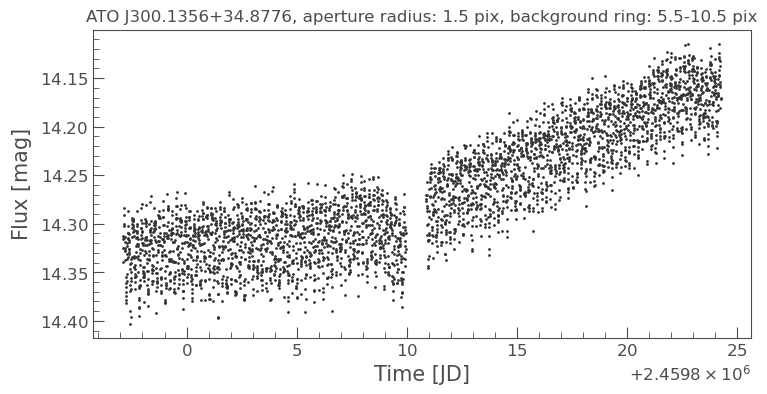

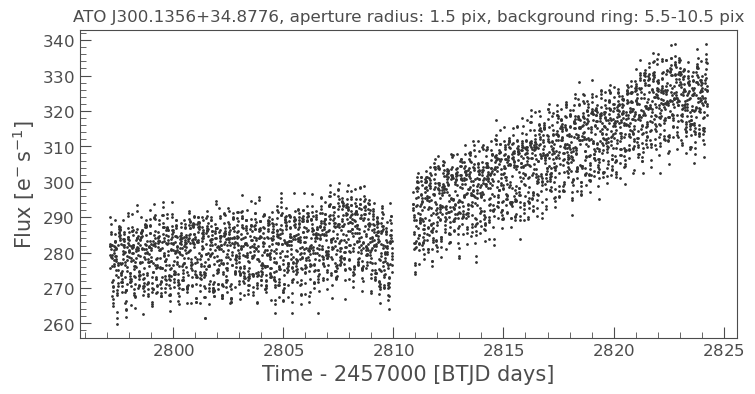

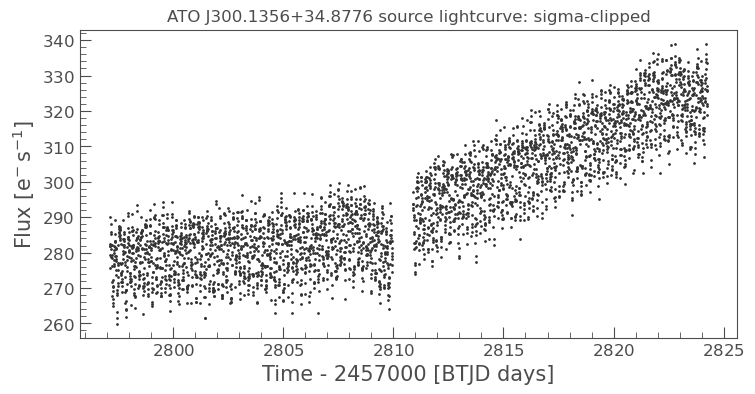

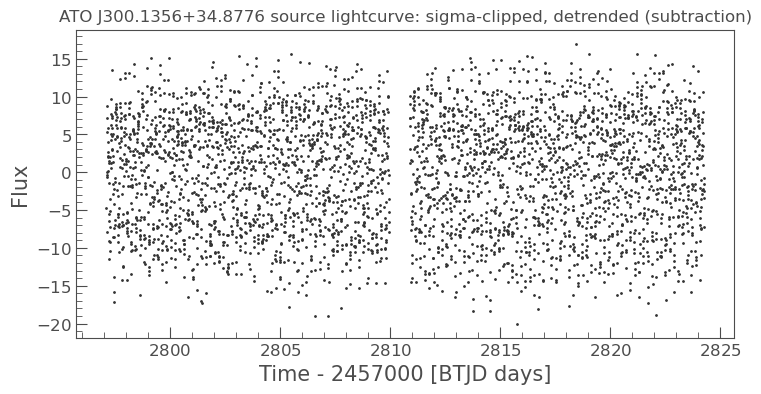

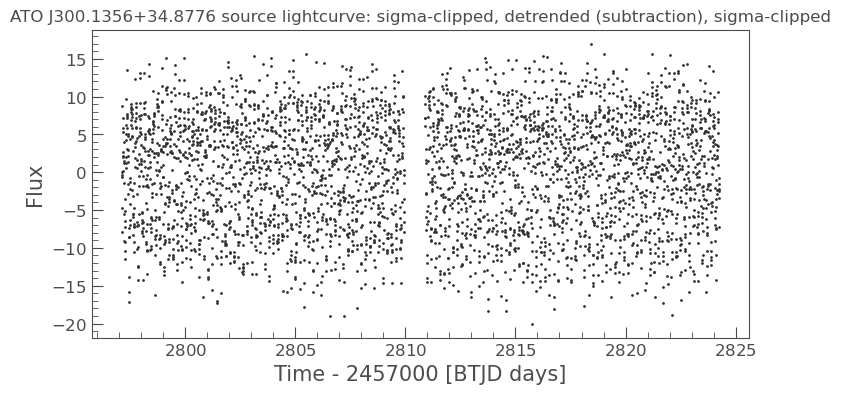

The best period is: 0.1987 d days


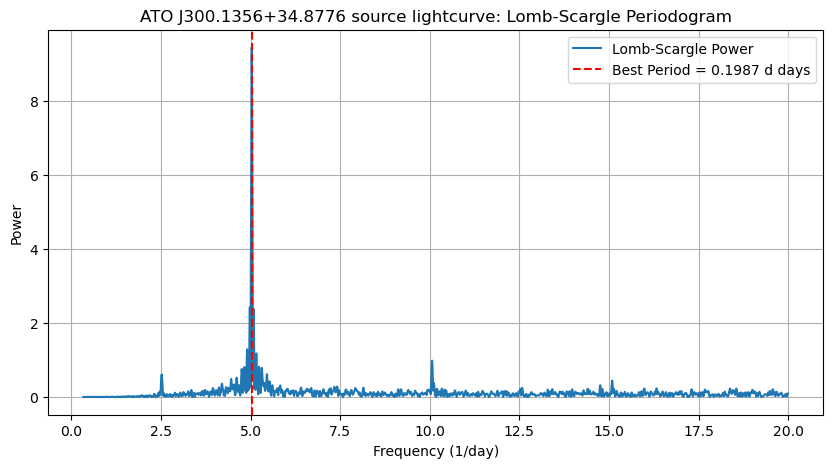

Fitted sine wave parameters:
  Amplitude: 9.444156
  Phase offset: -0.005071
  Vertical offset: -0.011373
  Phase of minimum: 0.744929


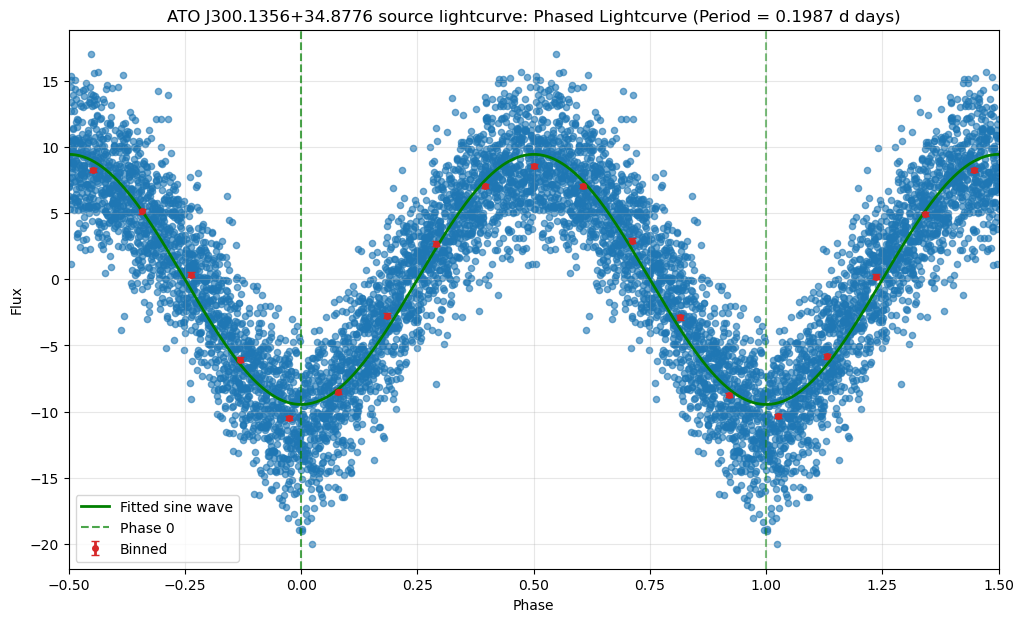

Plotting background lightcurve for ATO J300.1356+34.8776:
  - Data points: 3771
  - Time range: 2797.111 to 2824.263 BTJD
  - Background flux range: 177.0 to 289.7 e-/s/pix
  - Configuration: aperture radius: 1.5 pix, background ring: 5.5-10.5 pix


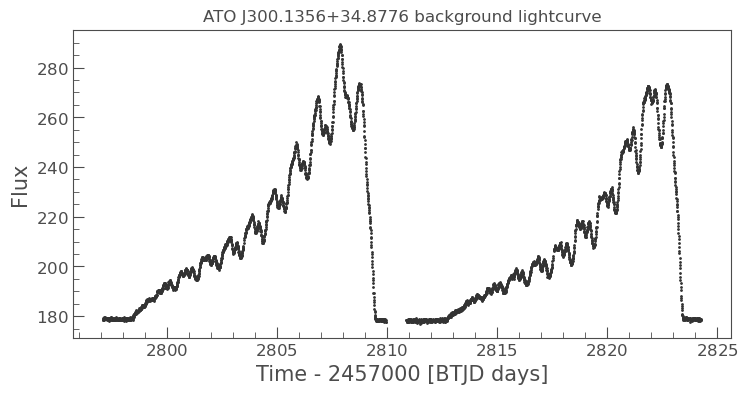

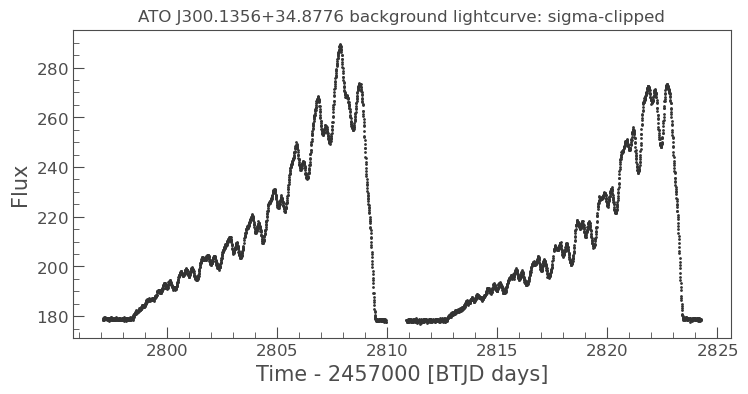

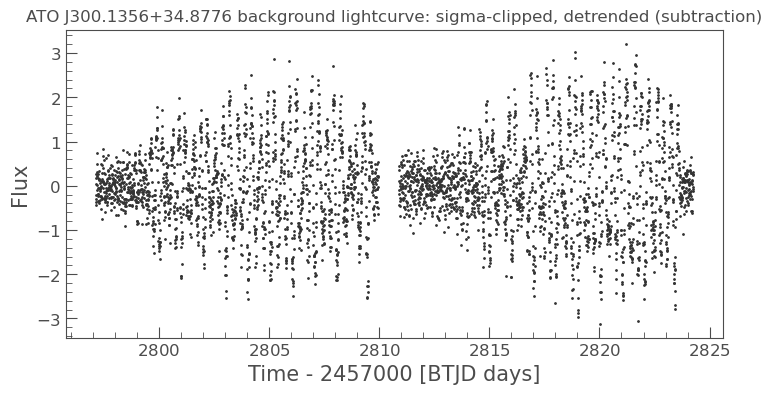

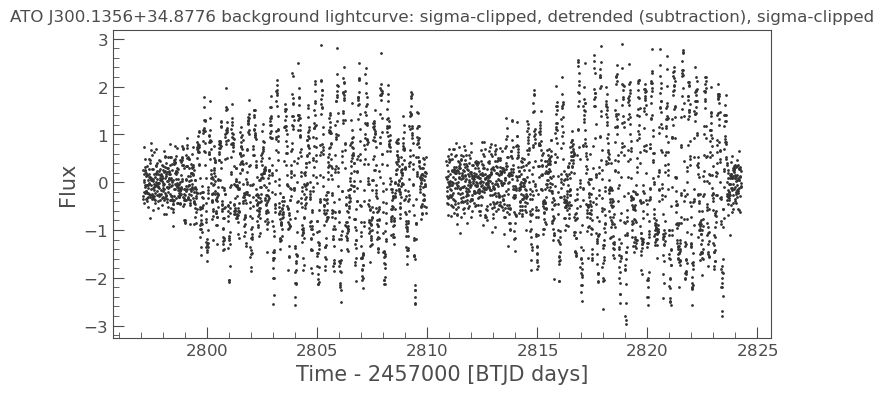

The best period is: 0.3334 d days


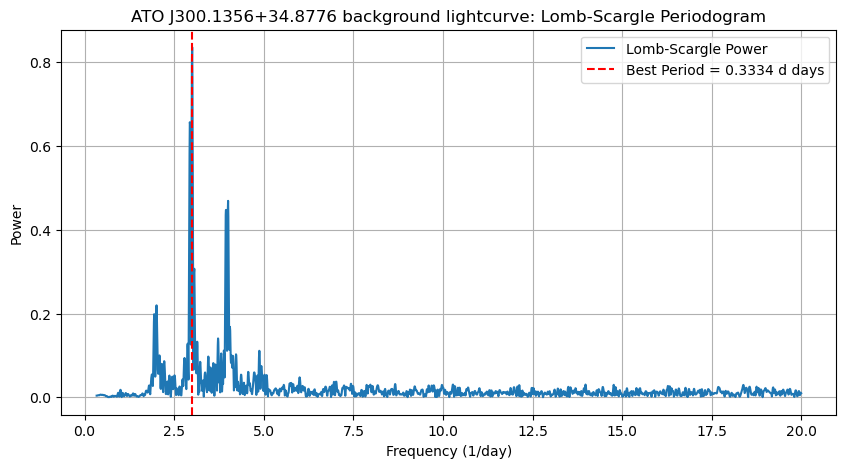

Fitted sine wave parameters:
  Amplitude: 0.835771
  Phase offset: 0.103238
  Vertical offset: -0.004040
  Phase of minimum: 0.853238


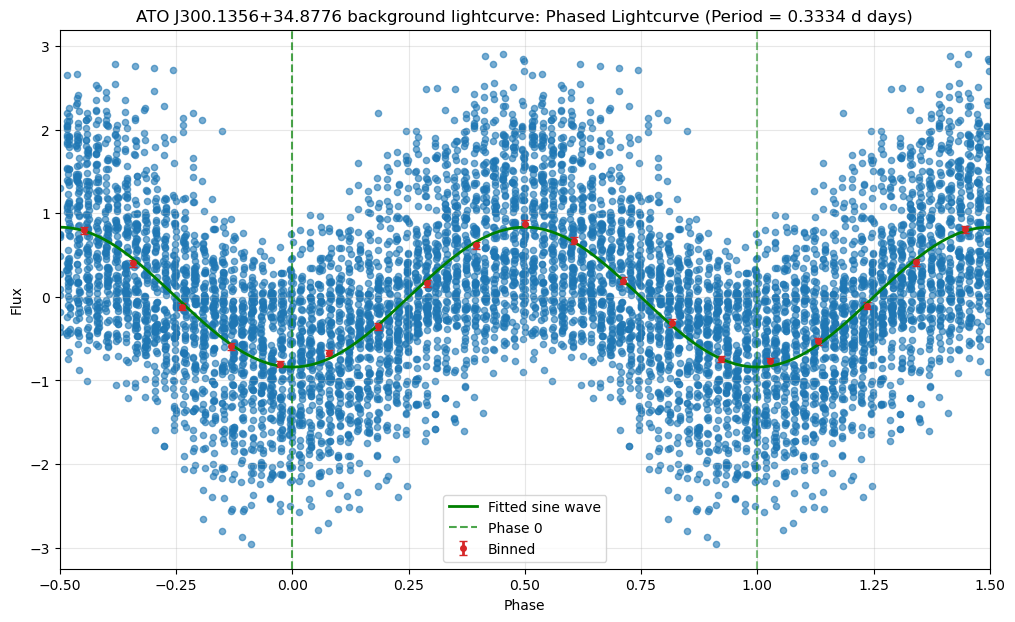

In [3]:
def radec_to_pixel(tpf, target_radec):
    """
    Convert RA/Dec coordinates to pixel coordinates in the TPF.

    Parameters:
    tpf (TargetPixelFile): The target pixel file object.
    target_radec (str): RA/Dec coordinates of the target.

    Returns:
    tuple: Pixel coordinates (x, y).
    """
    coord = SkyCoord.from_name(target_radec)  # Create a SkyCoord object from the RA/Dec string
    pixel = tpf.wcs.world_to_pixel(coord)  # Convert to pixel coordinates using WCS
    return pixel[0].item(), pixel[1].item()  # Return pixel coordinates as a tuple

def shots_sourcextractor_style_background_estimate_for_1d_data(annulus_data_1d):
    """
    Estimate the background value and standard deviation for 1D annulus data.

    Parameters:
    annulus_data_1d (array): 1D array of annulus data.

    Returns:
    tuple: Background value (median) and standard deviation.
    """
    if len(annulus_data_1d) == 0 or np.all(np.isnan(annulus_data_1d)):
        return np.nan, np.nan  # Return NaN if no valid data
    mean, median, std = sigma_clipped_stats(annulus_data_1d, sigma=3.0, cenfunc='median', stdfunc='mad_std')  # Perform sigma-clipped stats
    return median, std  # Return median and standard deviation

def custom_aperture_photometry_to_lightcurve(tpf, object_position, aperture_radius, annulus_inner_radius, annulus_outer_radius):
    """
    Perform aperture photometry on a target pixel file (TPF) and return a LightCurve object.

    Parameters:
    tpf (TargetPixelFile object): The target pixel file object.
    object_position (tuple): The position of the target (x, y) in pixels.
    aperture_radius (float): Radius of the circular aperture.
    annulus_inner_radius (float): Inner radius of the annular aperture.
    annulus_outer_radius (float): Outer radius of the annular aperture.

    Returns:
    LightCurve object: LightCurve object with the flux values for each cadence.
    """
    
    # Check that the input object position is reasonable
    if not np.all(np.isfinite(object_position)) :
        print("The input pixel position is not a finite number! -- skipping sector " + str(tpf_target.sector) + ' custom_aperture_photometry_to_lightcurve()' )
        return None, None, None

    # Check that the Targe Pixel File (cutout) is not too close to the frame edge
    if tpf_target.column < 44+annulus_outer_radius or tpf_target.column  > 2093-annulus_outer_radius :
        print("Too close to frame edge: tpf_target.column= " + str(tpf_target.column) + ' -- skipping sector ' + str(tpf_target.sector) + ' custom_aperture_photometry_to_lightcurve()')
        return None, None, None
    
    if tpf_target.row < annulus_outer_radius or tpf_target.row > 2049-annulus_outer_radius :
        print("Too close to frame edge: tpf_target.row= " + str(tpf_target.row) + ' -- skipping sector ' + str(tpf_target.sector) + ' custom_aperture_photometry_to_lightcurve()')
        return None, None, None

    flux_values = []
    flux_values_raw = []
    flux_values_bkg_per_pix = []
    flux_values_bkg_std_per_aperture = []
    time_values = tpf.time  # Assuming 'time' attribute is present in tpf

    # Define apertures
    aperture = CircularAperture(object_position, r=aperture_radius)
    annulus_aperture = CircularAnnulus(object_position, r_in=annulus_inner_radius, r_out=annulus_outer_radius)
    sources_mask = tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)  # Create a mask for sources

    for cadence in tpf.flux:
        phot_table = aperture_photometry(cadence, aperture)  # Perform aperture photometry
        cadence[sources_mask] = np.nan  # Assign NaN values to masked pixels for background estimation

        annulus_masks = annulus_aperture.to_mask(method='center')  # Create annulus masks
        annulus_data = annulus_masks.multiply(cadence)  # Multiply masks with cadence
        annulus_data_1d = annulus_data[annulus_masks.data > 0]  # Extract 1D annulus data

        bkg_value, std = shots_sourcextractor_style_background_estimate_for_1d_data(annulus_data_1d)  # Estimate background

        bkg_flux = bkg_value * aperture.area  # Calculate background flux
        bkg_std_per_aperture = std * aperture.area  # Calculate background standard deviation per aperture
        final_flux_raw = phot_table['aperture_sum']  # Extract raw flux
        final_flux = phot_table['aperture_sum'] - bkg_flux  # Subtract background from flux

        if final_flux[0].value <= 0.0:
            final_flux[0] = np.nan  # Assign NaN to negative or zero background-subtracted flux values

        if final_flux[0].value <= 20.0:
            final_flux[0] = np.nan  # Assign NaN to suspiciously low background-subtracted flux values
        
        if final_flux_raw[0].value <= 50.0:
            final_flux[0] = np.nan  # Assign NaN to suspiciously low raw flux values

        flux_values.append(final_flux[0])  # Append final flux value
        flux_values_raw.append(final_flux_raw[0])  # Append raw flux value
        flux_values_bkg_per_pix.append(bkg_value)  # Append background value per pixel
        flux_values_bkg_std_per_aperture.append(bkg_std_per_aperture)  # Append background standard deviation per aperture

    flux_values_unit = flux_values[0].unit  # Extract units from flux values
    flux_values = np.array([f.value for f in flux_values]) * flux_values_unit  # Convert flux values to array with units
    flux_values_raw = np.array([f.value for f in flux_values_raw]) * flux_values_unit  # Convert raw flux values to array with units
    flux_values_bkg_per_pix = np.array([f.value for f in flux_values_bkg_per_pix])  # Convert background values to array

    bkg_median, bkg_std = shots_sourcextractor_style_background_estimate_for_1d_data(flux_values_bkg_per_pix)  # Estimate background
    bkg_threshold = bkg_median + 10 * bkg_std  # Calculate background threshold

    high_bkg_mask = flux_values_bkg_per_pix > bkg_threshold  # Create mask for high background values
    flux_values[high_bkg_mask] = np.nan  # Assign NaN to high background flux values
    flux_values_raw[high_bkg_mask] = np.nan  # Assign NaN to high background raw flux values

    lc_bkg_subtracted = LightCurve(time=time_values, flux=flux_values, flux_err=flux_values_bkg_std_per_aperture)  # Create LightCurve for background-subtracted flux
    lc_raw = LightCurve(time=time_values, flux=flux_values_raw, flux_err=flux_values_bkg_std_per_aperture)  # Create LightCurve for raw flux
    lc_bkg_per_pix = LightCurve(time=time_values, flux=flux_values_bkg_per_pix)  # Create LightCurve for background per pixel

    
    # Determine the middle cadence and its data
    middle_cadence_index = len(tpf.flux) // 2
    middle_cadence = tpf.flux[middle_cadence_index]
    # Visualize the apertures for the middle cadence
    norm = simple_norm(middle_cadence, 'sqrt')
    plt.imshow(middle_cadence, cmap='gray', norm=norm, origin='lower')
    aperture.plot(color='blue', lw=1.5, alpha=0.5)  # Plot circular aperture
    annulus_aperture.plot(color='red', lw=1.5, alpha=0.5)  # Plot annular aperture
    plt.title(f"TESS Sector {tpf_target.sector}, aperture radius {r} pix, background region {ann_inner}-{ann_outer} pix")
    plt.colorbar()
    plt.show()
    
    return lc_bkg_subtracted, lc_raw, lc_bkg_per_pix  # Return LightCurve objects

def convert_flux_to_mag(time, flux, flux_err):
    """
    Convert flux to magnitudes.

    Parameters:
    time (array): Time values.
    flux (array): Flux values.
    flux_err (array): Flux error values.

    Returns:
    array: Time, magnitude, magnitude error.
    """
    flux = flux.value  # Remove units for log10 calculation
    flux_err = flux_err.value  # Remove units for log10 calculation
    mag = 20.44 - 2.5 * np.log10(flux)  # Convert flux to magnitude
    mag_err = -2.5 * np.log10((flux - flux_err) / flux)  # Calculate magnitude error
    #time_jd = 2457000.0 + time.jd  # Convert TESS JD to regular JD
    time_jd = time.jd
    return time_jd, mag, mag_err  # Return time, magnitude, and magnitude error

# Define target list
target_list = [
    ('PGIR22akgylf', '20:00:29.26 +34:53:09.1'),
    ('TYC 2678-1207-1', '20:00:30.1586813 +34:51:34.456302'),
    ('ATO J300.1356+34.8776', '20:00:32.5503041 +34:52:39.529398'),
]

stored_lc_targets = []  # List to store target lightcurves
stored_lc_aperture = []  # List to store aperture lightcurves

# Define aperture and annulus radii
#aperture_radii = [1.5, 2.0, 2.5]
aperture_radii = [1.5]
#annulus_radii_pairs = [(3.5, 10.5), (3.5, 7.5), (5.5, 10.5)]
annulus_radii_pairs = [(5.5, 10.5)]

# Create output directory
notebook_name = "PGIR22akgylf_lk_circular_aperture"
output_dir = notebook_name.lower().replace(" ", "_")
os.makedirs(output_dir, exist_ok=True)

for target_name, target_radec in target_list:
    print(f"Target Name: {target_name}")
    print(f"Target RA/DEC: {target_radec}")
    search_lc = lk.search_tesscut(target_radec)  # Search TESSCut for the target
    print(search_lc)

    lightcurves_input_position = {}  # Dictionary to store lightcurves with input position
    lightcurves_background_per_pix = {} # Dictionary to store background lightcurves

    # Analyze all sectors available for the source
    #for search_result in search_lc:
    # Analize one manually selected sector (that's Sector 41)
    for search_result in search_lc[3]:
        tpf_target = search_result.download(cutout_size=24, quality_bitmask=qualitycuts)  # Download the target pixel file
        if tpf_target is None:
            continue

        # Initial check that the Targe Pixel File (cutout) is not too close to the frame edge
        if tpf_target.column < 44+10 or tpf_target.column  > 2093-10 :
            print("Too close to frame edge: tpf_target.column= " + str(tpf_target.column) + ' -- skipping sector ' + str(tpf_target.sector) + ' (main script)')
            continue
        if tpf_target.row < 10 or tpf_target.row > 2049-10 :
            print("Too close to frame edge: tpf_target.row= " + str(tpf_target.row) + ' -- skipping sector ' + str(tpf_target.sector) + ' (main script)')
            continue

        initial_x, initial_y = radec_to_pixel(tpf_target, target_radec)  # Convert RA/Dec to pixel coordinates
        # Check that the input object position is reasonable
        if not np.all(np.isfinite( (initial_x, initial_y) )) :
            print("The input pixel position is not a finite number! -- skipping sector " + str(tpf_target.sector) + ' (main script)' )
            continue

        for r in aperture_radii:
            for ann_inner, ann_outer in annulus_radii_pairs:
                print(f"Extracting TESS Sector {tpf_target.sector} lightcurve of {target_name} with aperture radius {r} pix and background region {ann_inner}-{ann_outer} pix")

                
                # Perform aperture photometry placing the aperture at the source position derived from the input celestial coordinates
                print(f'Placing the aperture at the input coordinates of {target_name}')
                lc_bkg_subtracted_input, lc_raw_input, lc_bkg_per_pix_input = custom_aperture_photometry_to_lightcurve(
                    tpf_target, (initial_x, initial_y), r, ann_inner, ann_outer)
                
                # Check if something went wrong during the lightcurve creation
                # (like target too close to the frame edge)
                if lc_bkg_subtracted_input is None:
                    continue
                
                key = (r, ann_inner, ann_outer, 'input_position')
                if key not in lightcurves_input_position:
                    lightcurves_input_position[key] = lc_bkg_subtracted_input
                else:
                    lightcurves_input_position[key] = lightcurves_input_position[key].append(lc_bkg_subtracted_input)
                
                # Store background lightcurve
                key = (r, ann_inner, ann_outer, 'background')
                if key not in lightcurves_background_per_pix:
                    lightcurves_background_per_pix[key] = lc_bkg_per_pix_input
                else:
                    lightcurves_background_per_pix[key] = lightcurves_background_per_pix[key].append(lc_bkg_per_pix_input)

    def mad(data, axis=None):
        """
        Calculate Median Absolute Deviation (MAD).

        Parameters:
        data (array): Data values.
        axis (int): Axis along which the MAD is calculated.

        Returns:
        float: MAD value.
        """
        median = np.nanmedian(data, axis=axis)  # Calculate median
        mad = np.nanmedian(np.abs(data - median), axis=axis)  # Calculate MAD
        return mad  # Return MAD value

    min_mad_value = float('inf')  # Initialize minimum MAD value
    best_lightcurve = None  # Initialize best lightcurve
    best_description = ""  # Initialize description for the best lightcurve
    best_background_lightcurve = None  # Initialize best background lightcurve

    # Evaluate lightcurves with input position
    for key, lc in lightcurves_input_position.items():
        r, ann_inner, ann_outer, method = key
        lc = lc.remove_nans()  # Remove NaN values
        mad_value = mad(lc.flux)  # Calculate MAD value
        print(f'MAD for {method}, aperture radius {r}, annulus {ann_inner}-{ann_outer}: {mad_value}')
        if mad_value < min_mad_value:
            min_mad_value = mad_value
            best_lightcurve = lc
            best_description = f'aperture radius: {r} pix, background ring: {ann_inner}-{ann_outer} pix'
            # Get corresponding background lightcurve
            background_key = (r, ann_inner, ann_outer, 'background')
            temp_background = lightcurves_background_per_pix[background_key]
            # Make sure to only keep background measurements that correspond to the times in best_lightcurve
            best_background_lightcurve = LightCurve(
                time=lc.time,
                flux=temp_background.flux[np.isin(temp_background.time.value, lc.time.value)]
            )
        title = f"{target_name}_r{r}_ann{ann_inner}-{ann_outer}_{method}"
        output_filename_csv = os.path.join(output_dir, title.replace(" ", "_") + '_TESS_lk_circap.csv')
        if WRITE_ALL_LIGHTCURVES:
            lc.to_csv(output_filename_csv, overwrite=True)
            print(f'Writing file {output_filename_csv}')

    # Save the best lightcurve
    if best_lightcurve is not None:
        print(f'Best lightcurve: {best_description}')
        
        # Filter background lightcurve to match best lightcurve timestamps
        # First remove NaNs from best lightcurve to get valid timestamps
        valid_times = ~np.isnan(best_lightcurve.flux)
        best_lightcurve_clean = LightCurve(
            time=best_lightcurve.time[valid_times],
            flux=best_lightcurve.flux[valid_times],
            flux_err=best_lightcurve.flux_err[valid_times] if best_lightcurve.flux_err is not None else None
        )
        
        # Create a matching background lightcurve
        # Use isin to match the timestamps exactly
        matching_times = np.isin(best_background_lightcurve.time.value, best_lightcurve_clean.time.value)
        best_background_lightcurve_clean = LightCurve(
            time=best_background_lightcurve.time[matching_times],
            flux=best_background_lightcurve.flux[matching_times]
        )
        
        if WRITE_BEST_LIGHTCURVE_ELECTRONS:
            best_output_filename_csv = os.path.join(output_dir, f"{target_name.replace(' ', '_')}_best_TESS_lightcurve.csv")
            best_lightcurve_clean.to_csv(best_output_filename_csv, overwrite=True)
            print(f'Writing best lightcurve to file {best_output_filename_csv}')
            
            # Save corresponding background lightcurve
            best_background_filename_csv = os.path.join(output_dir, f"{target_name.replace(' ', '_')}_best_TESS_background.csv")
            best_background_lightcurve_clean.to_csv(best_background_filename_csv, overwrite=True)
            print(f'Writing best background lightcurve to file {best_background_filename_csv}')

        if WRITE_BEST_LIGHTCURVE_MAGNITUDES:
            # Convert the best lightcurve to magnitudes and write to a new file
            time_jd, mag, mag_err = convert_flux_to_mag(best_lightcurve_clean.time, 
                                                       best_lightcurve_clean.flux, 
                                                       best_lightcurve_clean.flux_err)
            best_lightcurve_mag = np.column_stack((time_jd, mag, mag_err))
            best_mag_output_filename = os.path.join(output_dir, f"{target_name.replace(' ', '_')}_best_TESS_lightcurve_mag.dat")
            np.savetxt(best_mag_output_filename, best_lightcurve_mag, delimiter=' ', fmt='%.6f %.6f %.6f')
            print(f'Writing best lightcurve (magnitudes) to file {best_mag_output_filename}')
            # Create magnitude LightCurve object for plotting
            best_lightcurve_mag_LightCurve = LightCurve(
                time=time_jd,
                flux=mag * u.mag,  # Specify magnitude units,
                flux_err=mag_err * u.mag  # Specify magnitude units
            )
            print(f'Plotting magnitude lightcurve for {target_name}:')
            print(f'  - Data points: {len(time_jd)}')
            print(f'  - Time range: {time_jd.min():.3f} to {time_jd.max():.3f} JD')
            print(f'  - Magnitude range: {mag.min():.3f} to {mag.max():.3f} mag')
            print(f'  - Configuration: {best_description}')
            best_lightcurve_mag_LightCurve.plot(lw=2, marker='.', linestyle='None')
            plt.gca().invert_yaxis()  # Invert the y-axis
            plt.title(f"{target_name}, {best_description}")
            plt.savefig(os.path.join(output_dir, f"{target_name.replace(' ', '_')}_best_TESS_lightcurve_mag.png"), dpi=300)
            plt.savefig(os.path.join(output_dir, f"{target_name.replace(' ', '_')}_best_TESS_lightcurve_mag.eps"), format="eps")
            
        # Display the best lightcurve in its own figure
        print(f'Plotting flux lightcurve for {target_name}:')
        print(f'  - Data points: {len(best_lightcurve_clean.time)}')
        print(f'  - Time range: {best_lightcurve_clean.time.min().value:.3f} to {best_lightcurve_clean.time.max().value:.3f} BTJD')
        print(f'  - Flux range: {best_lightcurve_clean.flux.min().value:.1f} to {best_lightcurve_clean.flux.max().value:.1f} e-/s')
        print(f'  - Configuration: {best_description}')
        best_lightcurve_clean.plot(lw=2, marker='.', linestyle='None')
        plt.title(f"{target_name}, {best_description}")
        # Save plot to file
        if WRITE_BEST_LIGHTCURVE_ELECTRONS:
            plt.savefig(os.path.join(output_dir, f"{target_name.replace(' ', '_')}_best_TESS_lightcurve.png"), dpi=300)
            plt.savefig(os.path.join(output_dir, f"{target_name.replace(' ', '_')}_best_TESS_lightcurve.eps"), format="eps")

        # Run the period analysis on the source lightcurve
        simple_detrend_and_period_search(best_lightcurve_clean, period_range=(0.05, 3.0), titleprefixstring=f"{target_name} source lightcurve:")
        
        # Display the corresponding background lightcurve in a separate figure
        print(f'Plotting background lightcurve for {target_name}:')
        print(f'  - Data points: {len(best_background_lightcurve_clean.time)}')
        print(f'  - Time range: {best_background_lightcurve_clean.time.min().value:.3f} to {best_background_lightcurve_clean.time.max().value:.3f} BTJD')
        print(f'  - Background flux range: {best_background_lightcurve_clean.flux.min():.1f} to {best_background_lightcurve_clean.flux.max():.1f} e-/s/pix')
        print(f'  - Configuration: {best_description}')
        best_background_lightcurve_clean.plot(lw=2, marker='.', linestyle='None')
        plt.title(f"{target_name} background lightcurve")
        # Save plot to file
        if WRITE_BEST_LIGHTCURVE_ELECTRONS:
            plt.savefig(os.path.join(output_dir, f"{target_name.replace(' ', '_')}_background_lightcurve.png"), dpi=300)
            plt.savefig(os.path.join(output_dir, f"{target_name.replace(' ', '_')}_background_lightcurve.eps"), format="eps")

        # Run the period analysis on the source lightcurve
        simple_detrend_and_period_search(best_background_lightcurve_clean, period_range=(0.05, 3.0), titleprefixstring=f"{target_name} background lightcurve:")

In [4]:
lk.show_citation_instructions()